In [1]:
import numpy as np
import itertools
import random
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

from jenga.cleaning.ppp import PipelineWithPPP
from jenga.cleaning.autoclean import AutoClean
from jenga.cleaning.outlier_removal import SKLearnIsolationForest
from jenga.cleaning.imputation import SimpleImputation

from jenga.corruptions.categorical import SwapValues
from jenga.corruptions.numerical import SwappedValues, Outliers, Scaling
from jenga.corruptions.text import BrokenCharacters
from jenga.corruptions.missing import ( MissingValuesHighEntropy, 
                                  MissingValuesLowEntropy, 
                                  MissingValues
                                )


# Titanic Example

In [2]:

np.random.seed(0)

# Load data from https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# We will train our classifier with the following features:
# Numeric Features:
# - age: float.
# - fare: float.
# Categorical Features:
# - embarked: categories encoded as strings {'C', 'S', 'Q'}.
# - sex: categories encoded as strings {'female', 'male'}.
# - pclass: ordinal integers {1, 2, 3}.

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['age', 'fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features),
        ('categorical_features', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.790


## PPP Model

In [3]:
from jenga.cleaning.ppp import PipelineWithPPP
ppp = PipelineWithPPP(clf, 
                      numerical_columns=numeric_features, 
                      categorical_columns=categorical_features,
                      num_repetitions=5,
                      perturbation_fractions=[.3, .5, .6, .75, .9]
                     )
ppp.fit_ppp(X_train, y_train)
print(f'Predicted score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')

Predicted score: 0.7755, true score 0.7863


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [4]:
# perturbation = Scaling(0.2, ['age','fare'])
perturbation = SwappedValues(0.4, ['age','fare'])
# perturbation = MissingValues(0.7, 'fare',0,'MAR')
X_corrupted = perturbation(X_test.copy())

ac = AutoClean(X_train, 
               y_train, 
               clf, 
               numerical_columns=['age','fare'], 
               categorical_columns=['embarked', 'sex', 'pclass'],
               outlier_removal=[SKLearnIsolationForest],
               imputation=[SimpleImputation],
               verbose=True
              )
X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
        'ppp_score_cleaned': ppp.predict_ppp(X_cleaned)
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

PPP score no cleaning 0.7691181152499205
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.769
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.771
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.769
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.771
Setting 27 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.776
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.744
Setting 27 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.756
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.74
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.776
perturbation:SwappedValues: {'fraction': 0.4, 'column_pair': ['age', 'fare']}
clean_data_test_score:0.7862595419847328
corrupted_data_test_score:0.7709923664122137
cleaned_data_test_score:0.744274

In [5]:
cleaner_results_ppp, cleaner_results_true

([0.7691181152499205,
  0.7691181152499205,
  0.7756765361349889,
  0.7562559694364853],
 [0.7709923664122137,
  0.7709923664122137,
  0.7442748091603053,
  0.7404580152671756])

# Toy Data Example

(-1.8774763389668039, 4.73916889797604, -1.7047546030348233, 6.633577833428513)

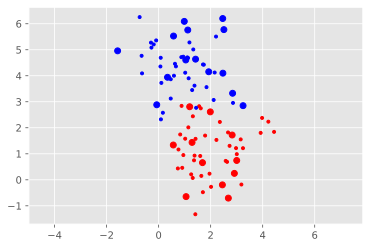

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_test.loc[y_test>0,0],X_test.loc[y_test>0,1],'ro',
         X_test.loc[y_test<=0,0],X_test.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

(-1.8774763389668039, 4.73916889797604, -2.199374182319021, 17.020588998396658)

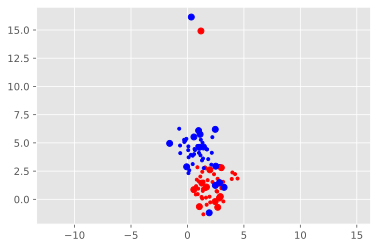

In [7]:
perturbation = Outliers(0.5, [1])
X_corrupted = perturbation(X_test.copy())

plt.plot(X_train.loc[y_train>0,0],X_train.loc[y_train>0,1],'r.',
         X_train.loc[y_train<=0,0],X_train.loc[y_train<=0,1],'b.',
        )
plt.plot(X_corrupted.loc[y_test>0,0],X_corrupted.loc[y_test>0,1],'ro',
         X_corrupted.loc[y_test<=0,0],X_corrupted.loc[y_test<=0,1],'bo',
        )
plt.axis('equal')

In [8]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = [0,1]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])
clf = clf.fit(X_train, y_train)
print(f'Clean Test Score {clf.score(X_test, y_test)}')
print(f'Corrupted Test Score {clf.score(X_corrupted, y_test)}')

Clean Test Score 0.88
Corrupted Test Score 0.76


In [9]:
from jenga.cleaning.ppp import PipelineWithPPP
ppp = PipelineWithPPP(clf, 
                      numerical_columns=numeric_features, 
                      categorical_columns=[],
                      num_repetitions=5,
                      perturbation_fractions=[.1,.3, .5, .6, .75, .9, .99]
                     )

ppp.fit_ppp(X_train, y_train)
print(f'Predicted clean score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')
print(f'Predicted corrupted score: {ppp.predict_ppp(X_corrupted):.4f}, true score {clf.score(X_corrupted, y_test):.4f}')


Predicted clean score: 0.8947, true score 0.8800
Predicted corrupted score: 0.8573, true score 0.7600


In [10]:
ac = AutoClean(X_train, 
               y_train, 
               clf, 
               numerical_columns=[0,1], 
               categorical_columns=[],
               outlier_removal=[SKLearnIsolationForest],
               imputation=[SimpleImputation],
               verbose=False
              )
X_cleaned, predicted_score, cleaner_results_ppp, cleaner_results_true  = ac(X_corrupted.copy(deep=True), y_test)

result = {
        'perturbation': perturbation,
        'clean_data_test_score': clf.score(X_test, y_test),
        'corrupted_data_test_score': clf.score(X_corrupted, y_test),
        'cleaned_data_test_score': clf.score(X_cleaned, y_test),
        'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
        'ppp_score_cleaned': ppp.predict_ppp(X_cleaned)
    }
print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    

perturbation:Outliers: {'fraction': 0.5, 'columns': [1]}
clean_data_test_score:0.88
corrupted_data_test_score:0.76
cleaned_data_test_score:0.76
ppp_score_corrupted:0.8573333333333333
ppp_score_cleaned:0.8573333333333333


In [11]:
cleaner_results_ppp, cleaner_results_true

([0.82, 0.82, 0.8093333333333332, 0.7706666666666667],
 [0.76, 0.76, 0.72, 0.72])

# OpenML Example

In [2]:
def _is_categorical(col: pd.Series,
                    n_samples: int = 100,
                    max_unique_fraction=0.05) -> bool:
    """
    A heuristic to check whether a column is categorical:
    a column is considered categorical (as opposed to a plain text column)
    if the relative cardinality is max_unique_fraction or less.
    :param col: pandas Series containing strings
    :param n_samples: number of samples used for heuristic (default: 100)
    :param max_unique_fraction: maximum relative cardinality.
    :return: True if the column is categorical according to the heuristic
    """
    if col.
    sample = col.sample(n=n_samples, replace=len(col) < n_samples).unique()

    return 

corruptions = {
    'numeric':[Outliers, Scaling],
    'categorical':[SwapValues],
    'missing': [MissingValuesHighEntropy, 
                MissingValuesLowEntropy, 
                MissingValues]
}

def get_random_perturbation(numerical_columns, 
                            categorical_columns, 
                            fractions=[.2, .5, .9]):
    '''
    Returns a random perturbation, chosen from either a numeric (swapping, outlier, scaling)
    or missingness
    '''
    
    if len(numerical_columns)>0 and len(categorical_columns)>0:
        perturbation_type = random.choice(list(corruptions.keys()))
    elif len(numerical_columns)>0:
        perturbation_type = 'numeric'
    elif len(categorical_columns)>0:
        perturbation_type = 'categorical'
    else:
        print("need at least one categorical or numeric column")
        
    random_fraction = random.choice(fractions)
    if perturbation_type is 'missing':
        missingness = random.choice(['MCAR', 'MAR', 'MNAR'])
        rand_column = random.choice(categorical_columns + numerical_columns)
        if rand_column in numerical_columns:
            missing_value = 0
        else:
            missing_value = ''
        return MissingValues(random_fraction, rand_column, missing_value, missingness)
    elif perturbation_type is 'numeric':
        perturbation = random.choice(corruptions[perturbation_type])
        rand_column = random.choice(numerical_columns)
        return perturbation(random_fraction, [rand_column])
    elif perturbation_type is 'categorical':
        rand_column = random.choice(categorical_columns)
        return SwapValues(random_fraction, rand_column)

# https://www.openml.org/search?q=qualities.NumberOfClasses%3A2%2520qualities.NumberOfInstances%3A100..10000%2520qualities.NumberOfFeatures%3A10..100&type=data
experiments = [
    'ionosphere',
    'sonar',
    'heart-statlog',
    'parkinsons',
    'KnuggetChase3',
    'Satellite',
    'fertility',
    'steel-plates-fault',
    'profb',
    'sick'
 ]


In [19]:
def run_experiment(exp_id):
    print("*"*80)
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)

#     categorical_features = [c for c in X.columns if _is_categorical(X[c])]
#     X[categorical_features] = X[categorical_features].astype(str)
    numeric_features = X._get_numeric_data().columns.tolist()
    categorical_features = list(set(X.columns) - set(numeric_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")


    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])

    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression())])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    ppp = PipelineWithPPP(clf, 
                          numerical_columns=numeric_features, 
                          categorical_columns=categorical_features,
                          num_repetitions=100,
                          perturbation_fractions=[.5, .6, .75, .9]
                         )
    ppp.fit_ppp(X_train, y_train)
    print(f'Predicted score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')
    perturbation = get_random_perturbation(numeric_features, categorical_features)
    print(perturbation)
    X_corrupted = perturbation(X_test.copy())

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numerical_columns=numeric_features, 
                   categorical_columns=categorical_features,
                   outlier_removal=[SKLearnIsolationForest],
                   imputation=[SimpleImputation],
                   verbose=True
                  )
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
            'ppp_score_cleaned': ppp.predict_ppp(X_cleaned),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result

In [5]:
results = []
for _ in range(10):
    try:
        results.append(run_experiment(random.choice(experiments)))
    except:
        pass

********************************************************************************
Fetching dataset fertility
Found 6 categorical and 3 numeric features
model score: 0.800


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9000, true score 0.8000
MissingValues: {'column': 'V5', 'fraction': 0.5, 'na_value': '', 'missingness': 'MCAR'}
PPP score no cleaning 0.9000000000000002
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.9
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.8
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.9
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.8
Setting 2 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.9
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.8
Setting 2 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.9
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.8
Cleaning did not improve score
perturbation:MissingValues: {'column': 'V5', 'fraction': 0.5, 'na_value': '', 'missingness': 'MCAR'}
clean_data_test_score:0.8


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.7927, true score 0.9231
Outliers: {'fraction': 0.5, 'columns': ['V14']}
PPP score no cleaning 0.797008547008547
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.797
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.974
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.797
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.974
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.749
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.872
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.782
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.974
Cleaning did not improve score
perturbation:Outliers: {'fraction': 0.5, 'columns': ['V14']}
clean_data_test_score:0.9230769230769231
corrupted_data_test_score:0.9743589743589743
clean

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8207, true score 0.8519
MissingValues: {'column': 'exercise_induced_angina', 'fraction': 0.2, 'na_value': '', 'missingness': 'MAR'}
PPP score no cleaning 0.7774691358024692
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.777
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.833
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.777
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.833
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.86
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.815
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.86
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.815
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.86
perturbation:MissingValues: {'column': 'exercise_

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8875, true score 0.8500
SwapValues: {'fraction': 0.2, 'column': 'V3'}
PPP score no cleaning 0.8874999999999997
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.887
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.85
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.887
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.85
Setting 2 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.887
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.85
Setting 2 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.887
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.85
Cleaning did not improve score
perturbation:SwapValues: {'fraction': 0.2, 'column': 'V3'}
clean_data_test_score:0.85
corrupted_data_test_score:0.85
cleaned_data_test_score:0.85
ppp_score_c

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9129, true score 0.7619
Outliers: {'fraction': 0.9, 'columns': ['attribute_17']}
PPP score no cleaning 0.8887550200803214
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.889
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.786
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.889
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.786
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.863
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.69
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.886
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.762
Cleaning did not improve score
perturbation:Outliers: {'fraction': 0.9, 'columns': ['attribute_17']}
clean_data_test_score:0.7619047619047619
corrupted_data_test_score:0.7857

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.7761, true score 0.7616
Outliers: {'fraction': 0.5, 'columns': ['T4U']}
PPP score no cleaning 0.7282399734835929
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.728
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.752
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.728
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.752
Setting 76 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.697
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.698
Setting 76 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.802
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.788
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.802
perturbation:Outliers: {'fraction': 0.5, 'columns': ['T4U']}
clean_data_test_score:0.7615894039735099
co

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8407, true score 0.8732
SwapValues: {'fraction': 0.2, 'column': 'a01'}
PPP score no cleaning 0.8388095238095237
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.839
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.803
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.839
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.803
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.8
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.817
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.901
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.718
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.901
perturbation:SwapValues: {'fraction': 0.2, 'column': 'a01'}
clean_data_test_score:0.8732394366197183
corrupte

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8491, true score 0.8889
MissingValues: {'column': 'exercise_induced_angina', 'fraction': 0.9, 'na_value': '', 'missingness': 'MCAR'}
PPP score no cleaning 0.8632716049382715
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.863
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.889
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.863
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.889
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.86
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.833
Setting 6 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.865
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.833
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.865
perturbation:MissingValues: {'column': 'exerci

In [6]:
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')

In [7]:
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')
cleaner_ppp = list(itertools.chain(*df_results['cleaner_results_ppp']))
cleaner_true = list(itertools.chain(*df_results['cleaner_results_true']))

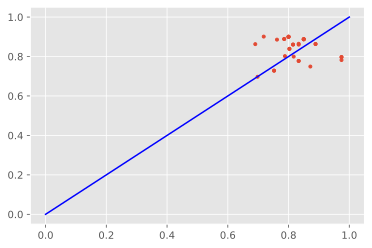

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df_results = pd.DataFrame(results)
df_results.to_csv('results_linear.csv')
cleaner_ppp = list(itertools.chain(*df_results['cleaner_results_ppp']))
cleaner_true = list(itertools.chain(*df_results['cleaner_results_true']))
plt.plot(cleaner_true, cleaner_ppp, '.',[0,1],[0,1],'b-')

In [17]:
def run_experiment_nonlinear(exp_id):
    print("*"*80)
    print(f'Fetching dataset {exp_id}')
    X, y = fetch_openml(exp_id, version=1, as_frame=True, return_X_y=True)

#     categorical_features = [c for c in X.columns if _is_categorical(X[c])]
#     X[categorical_features] = X[categorical_features].astype(str)
#     numeric_features = list(set(X.columns) - set(categorical_features))
    numeric_features = X._get_numeric_data().columns.tolist()
    categorical_features = list(set(X.columns) - set(numeric_features))
    print(f"Found {len(categorical_features)} categorical and {len(numeric_features)} numeric features")


    # We create the preprocessing pipelines for both numeric and categorical data.
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical_features', numeric_transformer, numeric_features),
            ('categorical_features', categorical_transformer, categorical_features)])

    
    param_grid = {
            'n_estimators': np.arange(5, 100, 10)
        }

    classifier = GridSearchCV(RandomForestClassifier(), param_grid)
        
    # Append classifier to preprocessing pipeline.
    # Now we have a full prediction pipeline.
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', classifier)])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    clf.fit(X_train, y_train)
    print("model score: %.3f" % clf.score(X_test, y_test))

    ppp = PipelineWithPPP(clf, 
                          numerical_columns=numeric_features, 
                          categorical_columns=categorical_features,
                          num_repetitions=20,
                          perturbation_fractions=[.1, .2, .5, .6, .9]
                         )
    ppp.fit_ppp(X_train, y_train)
    print(f'Predicted score: {ppp.predict_ppp(X_test):.4f}, true score {clf.score(X_test, y_test):.4f}')

    perturbation = get_random_perturbation(numeric_features, categorical_features)
    print(perturbation)
    X_corrupted = perturbation(X_test.copy())

    ac = AutoClean(X_train, 
                   y_train, 
                   clf, 
                   numerical_columns=numeric_features, 
                   categorical_columns=categorical_features,
                   outlier_removal=[SKLearnIsolationForest],
                   imputation=[SimpleImputation],
                   verbose=True
                  )
    X_cleaned, predicted_score_no_cleaning, cleaner_results_ppp, cleaner_results_true = ac(X_corrupted.copy(deep=True), test_labels=y_test)

    result = {
            'perturbation': perturbation,
            'clean_data_test_score': clf.score(X_test, y_test),
            'corrupted_data_test_score': clf.score(X_corrupted, y_test),
            'cleaned_data_test_score': clf.score(X_cleaned, y_test),
            'ppp_score_corrupted': ppp.predict_ppp(X_corrupted),
            'ppp_score_cleaned': ppp.predict_ppp(X_cleaned),
            'cleaner_results_ppp': cleaner_results_ppp,
            'cleaner_results_true': cleaner_results_true,
        }
    print('\n'.join([f'{k}:{v}' for k,v in result.items()]))
    return result

In [18]:
results_nonlinear = []
for _ in range(10):
    results_nonlinear.append(run_experiment_nonlinear(random.choice(experiments)))

df_results_nonlinear = pd.DataFrame(results_nonlinear)
df_results_nonlinear.to_csv('results_nonlinear.csv')

********************************************************************************
Fetching dataset KnuggetChase3
Found 0 categorical and 39 numeric features
model score: 0.744


/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9355, true score 0.7436
Scaling: {'fraction': 0.9, 'columns': ['ah']}
PPP score no cleaning 0.9298924731182796
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.93
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.744
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.93
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.744
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.93
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.744
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.93
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.744
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.93
perturbation:Scaling: {'fraction': 0.9, 'columns': ['ah']}
clean_data_test_score:0.7435897435897436
corrupted_dat

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8557, true score 0.6370
MissingValues: {'column': 'Pointspread', 'fraction': 0.2, 'na_value': 0, 'missingness': 'MAR'}
PPP score no cleaning 0.8553072625698324
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.855
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.63
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.74
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.644
Setting 14 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.859
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.652
Setting 14 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.734
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.652
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.859
perturbation:MissingValues: {'column': 'Pointspread', 'frac

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9267, true score 0.7000
Scaling: {'fraction': 0.5, 'columns': ['V2']}
PPP score no cleaning 0.9474999999999999
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.947
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.75
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.947
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.75
Setting 2 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.946
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.75
Setting 2 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.946
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.75
Cleaning did not improve score
perturbation:Scaling: {'fraction': 0.5, 'columns': ['V2']}
clean_data_test_score:0.7
corrupted_data_test_score:0.75
cleaned_data_test_score:0.75
ppp_score_co

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9907, true score 0.9859
Outliers: {'fraction': 0.2, 'columns': ['a17']}
PPP score no cleaning 0.9857142857142858
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.986
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.986
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.986
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.986
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.973
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.972
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.996
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.901
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.996
perturbation:Outliers: {'fraction': 0.2, 'columns': ['a17']}
clean_data_test_score:0.9859154929577465
corr

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9960, true score 0.8095
Outliers: {'fraction': 0.9, 'columns': ['attribute_20']}
PPP score no cleaning 0.9957831325301205
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.996
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.81
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.996
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.81
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.996
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.738
Setting 5 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.996
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.81
Cleaning did not improve score
perturbation:Outliers: {'fraction': 0.9, 'columns': ['attribute_20']}
clean_data_test_score:0.8095238095238095
corrupted_data_test_score:0.809523

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8707, true score 0.9437
Outliers: {'fraction': 0.5, 'columns': ['a01']}
PPP score no cleaning 0.890952380952381
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.891
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.944
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.891
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.944
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.896
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.944
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.994
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.845
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.994
perturbation:Outliers: {'fraction': 0.5, 'columns': ['a01']}
clean_data_test_score:0.9436619718309859
corru

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9800, true score 0.9437
Outliers: {'fraction': 0.2, 'columns': ['a13']}
PPP score no cleaning 0.9860714285714286
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.986
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.944
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.986
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.944
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.986
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.944
Setting 7 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.982
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.845
Cleaning did not improve score
perturbation:Outliers: {'fraction': 0.2, 'columns': ['a13']}
clean_data_test_score:0.9436619718309859
corrupted_data_test_score:0.9436619718309859
clea

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9643, true score 0.7436
Scaling: {'fraction': 0.2, 'columns': ['ac']}
PPP score no cleaning 0.9569892473118279
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.957
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.744
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.957
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.744
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.957
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.821
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.957
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.821
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.957
perturbation:Scaling: {'fraction': 0.2, 'columns': ['ac']}
clean_data_test_score:0.7435897435897436
corrupte

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.9833, true score 0.9487
Outliers: {'fraction': 0.2, 'columns': ['V10']}
PPP score no cleaning 0.9752136752136752
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.975
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.949
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.975
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.949
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.991
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.949
Setting 4 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.968
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.949
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.991
perturbation:Outliers: {'fraction': 0.2, 'columns': ['V10']}
clean_data_test_score:0.9487179487179487
corr

/Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Predicted score: 0.8767, true score 0.9000
Scaling: {'fraction': 0.2, 'columns': ['V8']}
PPP score no cleaning 0.8866666666666667
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.887
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.9
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.887
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.9
Setting 2 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.888
True score with cleaning <class 'jenga.cleaning.imputation.Imputation'>: 0.95
Setting 2 to NaN
PPP score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.881
True score with cleaning <class 'jenga.cleaning.imputation.SimpleImputation'>: 0.95
Best outlier removal <class 'type'> + best imputation <class 'type'>: 0.888
perturbation:Scaling: {'fraction': 0.2, 'columns': ['V8']}
clean_data_test_score:0.9
corrupted_data_test_score:0.9

In [16]:
debug

> /Users/felix/anaconda3/envs/ppp/lib/python3.6/site-packages/pandas/core/indexes/base.py(2394)__nonzero__()
   2392             "The truth value of a {0} is ambiguous. "
   2393             "Use a.empty, a.bool(), a.item(), a.any() or a.all().".format(
-> 2394                 self.__class__.__name__
   2395             )
   2396         )

ipdb> up
> /Users/felix/code/jenga/jenga/cleaning/ppp.py(59)__init__()
     57 
     58 
---> 59                 if self.numerical_columns:
     60                     num_col = random.choice(self.numerical_columns)
     61 

ipdb> self.numerical_columns
Index(['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG'], dtype='object')
ipdb> q


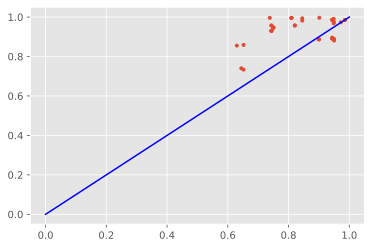

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
cleaner_ppp = list(itertools.chain(*df_results_nonlinear['cleaner_results_ppp']))
cleaner_true = list(itertools.chain(*df_results_nonlinear['cleaner_results_true']))
plt.plot(cleaner_true, cleaner_ppp, '.',[0,1],[0,1],'b-')

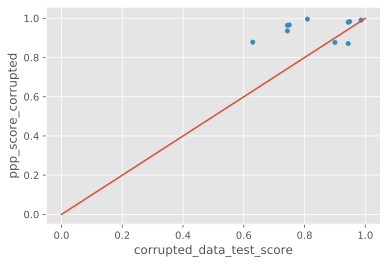

In [21]:
df_results_nonlinear.plot.scatter('corrupted_data_test_score','ppp_score_corrupted')
plt.plot([0,1],[0,1],'-')